# 0. Imports

In [1]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.ensemble import RandomForestClassifier

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [3]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [4]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [5]:
def calculate_metrics(y_pred, y_true, normalize = False):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = str(round(cr['1']['recall'],2))
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = str(round(cr['0']['recall'],2))
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.5 is: {}'.format(str(round(fbeta_score(y_true, y_pred,beta = 1.4),2))))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:

        if normalize == False:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')
        else:
            cm = confusion_matrix(y_true, y_pred, normalize='all')
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')

        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting a Decision Tree 

## On grayscale images

## Scale the data

In [6]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [7]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization and Grid Search. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [20]:
parameters = {'n_estimators': Integer(10,200, 'uniform'),'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth': Integer(2,1e10,prior='uniform'),
              'min_samples_split': Integer(2, 10, prior='uniform'), 'min_samples_leaf': Integer(1, 10, prior='uniform'),
              'min_weight_fraction_leaf':Real(0,0.5,prior='uniform'), 'max_features':[None,'sqrt','log2'],
              'max_leaf_nodes': Integer(5, 30, prior='uniform'), 'min_impurity_decrease':Real(0, 2, 'uniform'),
              'ccp_alpha':Real(0,1,'uniform'), 'max_samples': Real(0.2,1,'uniform')} 
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [21]:
opt = BayesSearchCV(RandomForestClassifier(random_state = 5000, class_weight= {0:1, 1:1.5}), parameters, n_iter = 200, scoring = fbeta_scorer, verbose = 5, random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ccp_alpha=0.8521957323049895, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=18, max_samples=0.47327133481828765, min_impurity_decrease=1.989590144429143, min_samples_leaf=1, min_samples_split=8, min_weight_fraction_leaf=0.0646968663559281, n_estimators=195;, score=0.723 total time=   0.3s
[CV 2/3] END ccp_alpha=0.8521957323049895, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=18, max_samples=0.47327133481828765, min_impurity_decrease=1.989590144429143, min_samples_leaf=1, min_samples_split=8, min_weight_fraction_leaf=0.0646968663559281, n_estimators=195;, score=0.721 total time=   0.4s
[CV 3/3] END ccp_alpha=0.8521957323049895, criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=18, max_samples=0.47327133481828765, min_impurity_decrease=1.989590144429143, min_samples_leaf=1, min_samples_split=8, min_weight_fraction_leaf=0.0646968663559281, n_estimators=195;, score=0.721 

In [22]:
print('Best score using 3-fold cross validation:', round(opt.best_score_,5))

Best score using 3-fold cross validation: 0.87628


In [23]:
print('Best parameters using 3-fold cross validation::', opt.best_params_)

Best parameters using 3-fold cross validation:: OrderedDict([('ccp_alpha', 0.0), ('criterion', 'entropy'), ('max_depth', 1781108027), ('max_features', None), ('max_leaf_nodes', 30), ('max_samples', 1.0), ('min_impurity_decrease', 0.0), ('min_samples_leaf', 1), ('min_samples_split', 3), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 200)])


## Trying Grid search CV

In [8]:
parameters = {'n_estimators': [50,150,200],'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth': [2,8,15,22,None],
              'max_features':[None, 'sqrt','log2'], 'class_weight': [{0:1, 1:1.5}], 'ccp_alpha':[0,0.3], 'max_samples': [0.45, 0.8,1], 
              'max_leaf_nodes': [None, 2, 6, 17]} 
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [9]:
opt_gs = GridSearchCV(RandomForestClassifier(random_state = 5000), parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 3240 candidates, totalling 9720 fits
[CV 1/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=50;, score=0.724 total time=   0.9s
[CV 2/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=50;, score=0.763 total time=   0.9s
[CV 3/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=50;, score=0.771 total time=   0.9s
[CV 1/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=150;, score=0.739 total time=   2.8s
[CV 2/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=150;, score=0.7

In [17]:
print('Best score using 3-fold cross validation:', round(opt_gs.best_score_,5))

Best score using 3-fold cross validation: 0.87961


In [11]:
print('Best parameters using 3-fold cross validation:', opt_gs.best_params_)

Best parameters using 3-fold cross validation: {'ccp_alpha': 0, 'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': 0.8, 'n_estimators': 200}


In [12]:
## Grid searching beyond 200 for parameter 'n_estimators' as it has taken a border grid

parameters = {'n_estimators': [220, 240],'criterion' : ['gini', 'entropy', 'log_loss'], 'max_depth': [2,8,15,22,None],
              'max_features':[None, 'sqrt','log2'], 'class_weight': [{0:1, 1:1.5}], 'ccp_alpha':[0,0.3], 'max_samples': [0.45, 0.8,1], 
              'max_leaf_nodes': [None, 2, 6, 17]} 
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                                                                                          

In [13]:
opt_gs2 = GridSearchCV(RandomForestClassifier(random_state = 5000), parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs2.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits
[CV 1/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=220;, score=0.736 total time=   3.4s
[CV 2/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=220;, score=0.779 total time=   3.0s
[CV 3/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=220;, score=0.780 total time=   4.0s
[CV 1/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=240;, score=0.726 total time=   4.2s
[CV 2/3] END ccp_alpha=0, class_weight={0: 1, 1: 1.5}, criterion=gini, max_depth=2, max_features=None, max_leaf_nodes=None, max_samples=0.45, n_estimators=240;, score=

In [16]:
print('Best score using 3-fold cross validation:', round(opt_gs2.best_score_,5))

Best score using 3-fold cross validation: 0.88069


In [15]:
print('Best parameters using 3-fold cross validation:', opt_gs2.best_params_)

Best parameters using 3-fold cross validation: {'ccp_alpha': 0, 'class_weight': {0: 1, 1: 1.5}, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': 0.8, 'n_estimators': 220}


But the score reduced when we extended the search space for parameters which had edge cases selected as best values.

### From the cross-validation scores, best model found by the first Grid Search.

In [24]:
clf = RandomForestClassifier(random_state=5000, **opt_gs.best_params_)
clf


RandomForestClassifier(ccp_alpha=0, class_weight={0: 1, 1: 1.5},
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_samples=0.8, n_estimators=200, random_state=5000)

Accuracy in detecting Accident class: 0.94

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.9  |              1    |
+-----------+-----------------------+-------------------+
| Recall    |                  1    |              0.87 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.95 |              0.93 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.87
Specificity/ ability to correctly classifiy to Non-Accident class is: 1.0

------------------------------------------------------------------------------------------

Fbeta score

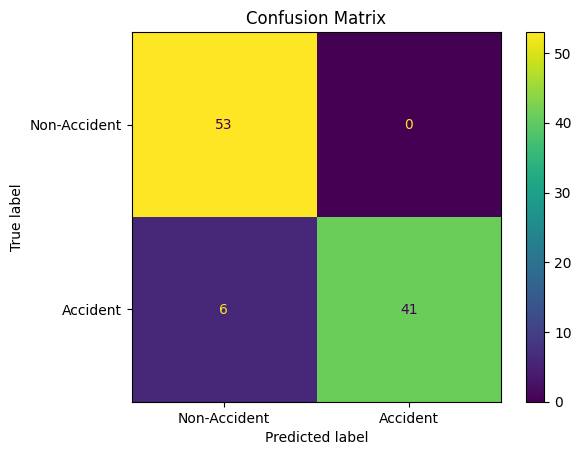


------------------------------------------------------------------------------------------



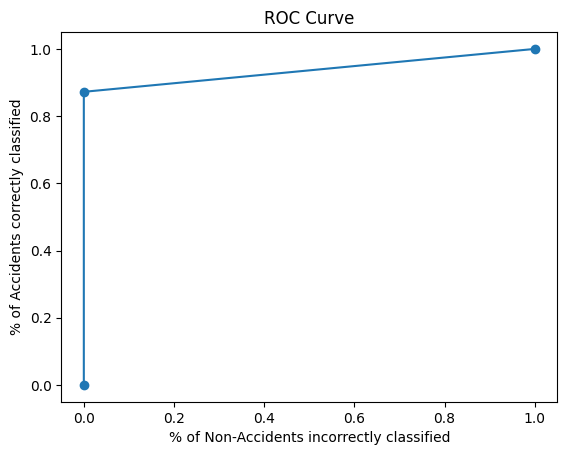


------------------------------------------------------------------------------------------

AUC score is: 0.94


In [25]:
clf.fit(X_train_gray_sc, y_train_final)
pred_gray_val = clf.predict(X_test_gray_sc)
calculate_metrics(pred_gray_val, y_test)

So, the best we could do using **Random Forest** is a test fbeta score (beta = 1.4) of 0.91, with the parameters:

- random_state = 5000
- 'ccp_alpha': 0
- 'class_weight': {0: 1, 1: 1.5}
- 'criterion': 'entropy'
- 'max_depth': 15
- 'max_features': 'log2'
- 'max_leaf_nodes': None
- 'max_samples': 0.8
- 'n_estimators': 200